# Title
Notebook by Jim Arnold

## Executive Summary
Concise summary and recommendations

## Introduction - Credit Card Transactions

Submit your results as a jupyter notebook and a written report (2-3 pages) highlighting the key results output of your notebook in this folder in the Fellows Folder.  Please title your submission, first_last_DC4

Submissions due Thursday 3/14 at 10am, which is when your peer review should happen with your partner. Group debrief is Thursday afternoon at 4pm.

###  Goal
One of the greatest data science challenges is fraud, and in general that area of data science related to catching illegal activities, because you often find yourself one step behind.
Your model is trained on past data. If users come up with a totally new way to commit a fraud, it often takes you some time to be able to react. By the time you get data about that new fraud strategy and retrain the model, many frauds have been already committed.
A way to overcome this is to use unsupervised machine learning, instead of supervised. With this approach, you don't need to have examples of certain fraud patterns in order to make a prediction. Often, this works by looking at the data and identify sudden clusters of unusual activities.

### Challenge Description
Company XYZ is a major credit card processing startup. It has information about all the transactions that users make with their credit card.
Your boss knows that fraud can be a huge cost for credit card companies, but isn’t sure if that’s true for your startup. She asks you to first determine if fraud is a major problem and second to implement an unsupervised algorithm that returns all transactions that seem unusual and are worth being investigated further by a human team of experts.

### Hints
Remember to quantify and describe how you quantify fraud today.  

How would you validate your model, how would you productionalize it?


### Data Description

#### cc_info - general information about the credit card and its holder
Columns:

credit_card : credit card number. Can be joined to credit_card in the table below 

city : where the credit card holder lives 

state : in which state the credit card holder lives 

zipcode : credit card holder zip code 

credit_card_limit : this is the credit card monthly limit. 

Credit card holders should be careful in not going above this limit in total money spent per month. The limit is by calendar month

#### transactions - information about each transaction that happens between Aug, 1 and Oct, 30 for the credit cards in cc_info.
Columns:

credit_card : credit card number. Can be joined to credit_card in the other table 

date : when the transaction happened (GMT time) 

transaction_dollar_amount : transaction amount in dollars

Long : longitude of where the transaction happened 

Lat : latitude of where the transaction happened



## Prepare Data

In [3]:
# Standard DS stack
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
# set plot defaults
sns.set(context='poster', style='white')

Load in data, check type and missingness.

In [65]:
# Import dataset(s) here, or connect to SQL
cc = pd.read_csv('cc_info.csv', dtype={'zipcode': object})
cc.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 984 entries, 0 to 983
Data columns (total 5 columns):
credit_card          984 non-null int64
city                 984 non-null object
state                984 non-null object
zipcode              984 non-null object
credit_card_limit    984 non-null int64
dtypes: int64(2), object(3)
memory usage: 38.5+ KB


In [66]:
# inspect
cc.head()

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,01501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


Looks like the leading 0 was dropped from the zip.

Let's try reading as an object. 

In [5]:
# Import dataset(s) here, or connect to SQL
tx = pd.read_csv('transactions.csv')
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null object
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: float64(3), int64(1), object(1)
memory usage: 11.2+ MB


In [271]:
# coerce datetime
tx = pd.read_csv('transactions.csv', parse_dates=['date'])
tx.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 294588 entries, 0 to 294587
Data columns (total 5 columns):
credit_card                  294588 non-null int64
date                         294588 non-null datetime64[ns]
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
dtypes: datetime64[ns](1), float64(3), int64(1)
memory usage: 11.2 MB


In [272]:
# engineer features for monthly, weekly, and daily calculations
tx.loc[:,'hour'] = tx.loc[:,'date'].dt.hour
tx.loc[:,'hourly'] = tx.loc[:,'date'].dt.floor('H') 
tx.loc[:,'daily'] = tx.loc[:,'date'].dt.floor('D') 
tx.loc[:,'monthly'] = tx.loc[:,'date'].dt.to_period('M') 
tx.loc[:,'weekday'] = tx.loc[:,'date'].dt.weekday

In [250]:
tx.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,0,2015-09-11 00:00:00,2015-09-11,2015-09,4
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,22,2015-10-24 22:00:00,2015-10-24,2015-10,5
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,18,2015-10-26 18:00:00,2015-10-26,2015-10,0
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,19,2015-10-22 19:00:00,2015-10-22,2015-10,3
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,20,2015-10-26 20:00:00,2015-10-26,2015-10,0


### playing with datetime index

In [225]:
tx.date.dt.floor('H').max()

Timestamp('2015-10-30 10:00:00')

In [229]:
tx.date.dt.floor('H').min()

Timestamp('2015-07-31 09:00:00')

In [230]:
pd.date_range(tx.date.dt.floor('H').min(), tx.date.dt.floor('H').max(), freq='H')

DatetimeIndex(['2015-07-31 09:00:00', '2015-07-31 10:00:00',
               '2015-07-31 11:00:00', '2015-07-31 12:00:00',
               '2015-07-31 13:00:00', '2015-07-31 14:00:00',
               '2015-07-31 15:00:00', '2015-07-31 16:00:00',
               '2015-07-31 17:00:00', '2015-07-31 18:00:00',
               ...
               '2015-10-30 01:00:00', '2015-10-30 02:00:00',
               '2015-10-30 03:00:00', '2015-10-30 04:00:00',
               '2015-10-30 05:00:00', '2015-10-30 06:00:00',
               '2015-10-30 07:00:00', '2015-10-30 08:00:00',
               '2015-10-30 09:00:00', '2015-10-30 10:00:00'],
              dtype='datetime64[ns]', length=2186, freq='H')

In [241]:
tx.shape

(294588, 9)

### Approach

This is an outlier detection problem, I want to find data points that deviate from the expected value. 

'Expected' value is kind of hard, but using common sense, I would think most cc users use their card in a habitual manner. 

That is, week-over-week, they'll visit the same stores and spend about the same amount. I want to see the distribution of all users first, and see if there are any underlying patterns (I imagine a businessman would have different spending habits than a octagenerian). 

The data covers 8/1 - 10/30, so we won't be able to test annual seasonality, but we might be able to use daily/ weekly signals.

Additionally, we have the cc users' home location, and the lat/lon of the transactions. We should be able to convert the home address to lat/long and use that to calculate a 'distance from home' metric for each transaction. I would then want to look at the distribution of distance. Similar to spend above, I think someone who travels more might have a different 'expected' pattern than someone more stationary, and that might be important.

My initial hypothesis is that we can use outliers with respect to amount and location to ID outliers. 

Depending on how well these work, may also need to engineer features for transaction frequency (I would imagine higher than normal # of transactions / time might need to be flagged). 

Based on the hint in the preface, the credit card limit might be important, too, but let's see if there's time.

## EDA

### Engineering home lat / long

To do this, I'm going to use a library I found online, uszipcode.

In [34]:
# Run on a test set

test = cc.head()
test

,credit_card,city,state,zipcode,credit_card_limit
0,1280981422329509,Dallas,PA,18612,6000
1,9737219864179988,Houston,PA,15342,16000
2,4749889059323202,Auburn,MA,01501,14000
3,9591503562024072,Orlando,WV,26412,18000
4,2095640259001271,New York,NY,10001,20000


In [54]:
from uszipcode import SearchEngine

search = SearchEngine(simple_zipcode=False)
def zip2lat(z):
    """Takes a given US zip code 'z'
    and returns the lat for given zip"""
    
    return search.by_zipcode(z).to_dict()['lat']
    
    
def zip2lon(z):
    """Takes a given US zip code 'z'
    and returns the lon for given zip"""
    
    return search.by_zipcode(z).to_dict()['lng']

In [55]:
# apply functions to cc test

test.loc[:,'lat'] = test.loc[:,'zipcode'].apply(zip2lat)
test.loc[:,'lon'] = test.loc[:,'zipcode'].apply(zip2lon)
test

,credit_card,city,state,zipcode,credit_card_limit,lat,lon
0,1280981422329509,Dallas,PA,18612,6000,41.30,-76.00
1,9737219864179988,Houston,PA,15342,16000,40.24,-80.22
2,4749889059323202,Auburn,MA,01501,14000,42.20,-71.85
3,9591503562024072,Orlando,WV,26412,18000,38.89,-80.56
4,2095640259001271,New York,NY,10001,20000,40.75,-73.99


After googling a few of the coordinates, it looks good. 

One observation = the folks that made this questions are tricky! Dallas and Houston PA? Orlando WV? zips don't lie.

In [67]:
# apply to cc df
cc.loc[:,'lat'] = cc.loc[:,'zipcode'].apply(zip2lat)
cc.loc[:,'lon'] = cc.loc[:,'zipcode'].apply(zip2lon)
cc.head(10)

,credit_card,city,state,zipcode,credit_card_limit,lat,lon
0,1280981422329509,Dallas,PA,18612,6000,41.30,-76.00
1,9737219864179988,Houston,PA,15342,16000,40.24,-80.22
2,4749889059323202,Auburn,MA,01501,14000,42.20,-71.85
3,9591503562024072,Orlando,WV,26412,18000,38.89,-80.56
4,2095640259001271,New York,NY,10001,20000,40.75,-73.99
5,1997929794676601,Atlanta,NY,14808,21000,42.57,-77.46
6,5449610971108305,Pittsburgh,PA,15201,6000,40.47,-79.95
7,7482288151831611,Birmingham,NJ,08011,4000,39.96,-74.65
8,8137811493121777,Washington,NH,03280,15000,43.19,-72.09
9,7804216189681274,Los Angeles,CA,90001,20000,33.97,-118.25


### Joining important features
It's not perfect, i.e. the Birmingham NJ zipcode doesn't line up. But that's an issue of the zip code, not the city. 
Moreover, it doesn't matter, I just need a relative fixed point to compare all the other transaction distances from. 

Next step is to calculate the distance of each transaction from home.

To do this, I'm going to left join the lat, lon, and (why they heck not) the credit_card_limit to the transaction table, using the credit_card feature.

In [273]:
# subset cc, then join the tx table
df = pd.merge(tx,cc[['credit_card','credit_card_limit', 'lat', 'lon']],on='credit_card', how='left')

In [274]:
# check data
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 294588 entries, 0 to 294587
Data columns (total 13 columns):
credit_card                  294588 non-null int64
date                         294588 non-null datetime64[ns]
transaction_dollar_amount    294588 non-null float64
Long                         294588 non-null float64
Lat                          294588 non-null float64
hour                         294588 non-null int64
hourly                       294588 non-null datetime64[ns]
daily                        294588 non-null datetime64[ns]
monthly                      294588 non-null object
weekday                      294588 non-null int64
credit_card_limit            294588 non-null int64
lat                          265169 non-null float64
lon                          265169 non-null float64
dtypes: datetime64[ns](3), float64(5), int64(4), object(1)
memory usage: 31.5+ MB


#### issue with some zip codes
hmm, there's missing features in the cc lat/long...

In [68]:
# get rows in cc where the zip didn't get converted
miss_coord = cc[cc['credit_card'].isin(df[df['lat'].isnull()]['credit_card'])]

In [70]:
miss_coord.head()

,credit_card,city,state,zipcode,credit_card_limit,lat,lon
13,8536914250563809,Colorado Springs,CO,80509,14000,NaN,NaN
16,2216132730528773,San Francisco,CA,94101,18000,NaN,NaN
32,1175962294549313,Arlington,MA,02174,14000,NaN,NaN
34,9595658147867468,Arlington,MA,02174,8000,NaN,NaN
35,2925559987432581,Tacoma,WA,98401,10000,NaN,NaN


These are data errors, the zipcodes are wrong for the associated city. 
probably something I can fix later if there's time, for now I'm going to drop them from the bigger df.

In [276]:
# inspect df
df = df[~df['lat'].isnull()]
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 265169 entries, 0 to 294587
Data columns (total 13 columns):
credit_card                  265169 non-null int64
date                         265169 non-null datetime64[ns]
transaction_dollar_amount    265169 non-null float64
Long                         265169 non-null float64
Lat                          265169 non-null float64
hour                         265169 non-null int64
hourly                       265169 non-null datetime64[ns]
daily                        265169 non-null datetime64[ns]
monthly                      265169 non-null object
weekday                      265169 non-null int64
credit_card_limit            265169 non-null int64
lat                          265169 non-null float64
lon                          265169 non-null float64
dtypes: datetime64[ns](3), float64(5), int64(4), object(1)
memory usage: 28.3+ MB


In [277]:
# double check
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,0,2015-09-11 00:00:00,2015-09-11,2015-09,4,20000,40.24,-80.22
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,22,2015-10-24 22:00:00,2015-10-24,2015-10,5,20000,40.24,-80.22
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,18,2015-10-26 18:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,19,2015-10-22 19:00:00,2015-10-22,2015-10,3,20000,40.24,-80.22
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,20,2015-10-26 20:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22


### Set index to hourly timestamp - don't 

In [255]:
#df.set_index('hourly',inplace=True)
#df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,daily,monthly,weekday,credit_card_limit,lat,lon
hourly,,,,,,,,,,,,
2015-09-11 00:00:00,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,0,2015-09-11,2015-09,4,20000,40.24,-80.22
2015-10-24 22:00:00,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,22,2015-10-24,2015-10,5,20000,40.24,-80.22
2015-10-26 18:00:00,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,18,2015-10-26,2015-10,0,20000,40.24,-80.22
2015-10-22 19:00:00,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,19,2015-10-22,2015-10,3,20000,40.24,-80.22
2015-10-26 20:00:00,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,20,2015-10-26,2015-10,0,20000,40.24,-80.22


### Calculate Transaction Distance from home

In [75]:
# Now, to calculate tx distance from home, I googled it and found the following,
# https://www.w3resource.com/python-exercises/math/python-math-exercise-27.php
# slightly modified:

from math import radians, sin, cos, acos

def dist_calc(row):
    """Takes a df with rows for transactions, uses: 
    starting lat and long, which is home location,
    ending lat and long, which is location of transaction,
    returns computed distance between start and end point in km"""
    
    # define starting coords
    slat = radians(row['lat'])
    slon = radians(row['lon'])
    
    # define ending coords
    elat = radians(row['Lat'])
    elon = radians(row['Long'])
    return 6371.01 * acos(sin(slat)*sin(elat) + cos(slat)*cos(elat)*cos(slon - elon))

In [80]:
# apply to test
test = df.head()
test['distance'] = test.apply(dist_calc, axis=1)

/home/jim/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  This is separate from the ipykernel package so we can avoid doing imports until


In [81]:
test.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,2015-09-11,2015-09-07/2015-09-13,2015-09,20000,40.24,-80.22,4.941044
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,2015-10-24,2015-10-19/2015-10-25,2015-10,20000,40.24,-80.22,7.009149
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,2015-10-26,2015-10-26/2015-11-01,2015-10,20000,40.24,-80.22,8.153301
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,2015-10-22,2015-10-19/2015-10-25,2015-10,20000,40.24,-80.22,6.868058
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,2015-10-26,2015-10-26/2015-11-01,2015-10,20000,40.24,-80.22,8.302105


Booyah! verified here: 
http://boulter.com/gps/distance/

Apply to the whole df. 

In [278]:
df['distance'] = df.apply(dist_calc, axis=1)

In [279]:
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,0,2015-09-11 00:00:00,2015-09-11,2015-09,4,20000,40.24,-80.22,4.941044
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,22,2015-10-24 22:00:00,2015-10-24,2015-10,5,20000,40.24,-80.22,7.009149
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,18,2015-10-26 18:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22,8.153301
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,19,2015-10-22 19:00:00,2015-10-22,2015-10,3,20000,40.24,-80.22,6.868058
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,20,2015-10-26 20:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22,8.302105


### Distance Distribution

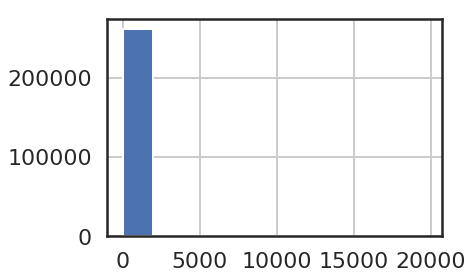

In [280]:
# OK, let's do some plots. 
# First, hist of the dist

df.distance.hist()

Definitely some extreme outliers... 
These should be easy to flag. 

However, it might be context dependent, like if someone is on vacation. If there's time I'll look into it.

### Spend Distribution

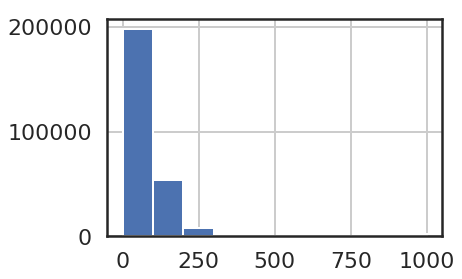

In [85]:
# hist of spend

df.transaction_dollar_amount.hist()

Might be some high expenses, but that alone might not indicate fraudulent activity. 

Using common sense, I would think that monthly credit limit would reflect buying power, and probably is related to average monthly spending. 

### Engineer Time Index

I want to be able to bin time by set increments

### Engineer Z-score 

I want to make a generic call to calculate z-scores for an individual transaction given a baseline unit of time.

I also want to look at one more feature, that is, the daily transaction frequency.

In [215]:
df.columns

Index(['credit_card', 'date', 'transaction_dollar_amount', 'Long', 'Lat',
       'daily', 'weekly', 'monthly', 'hourly', 'weekday', 'hour',
       'credit_card_limit', 'lat', 'lon', 'distance'],
      dtype='object')

In [283]:
# make a lambda func to calc Z-score, courtesy of SO
zscore = lambda x: (x - x.mean()) / x.std()

df.loc[:,'Z_daily_dist'] = df.groupby(['credit_card', 'daily'])['distance'].transform(zscore)
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance,Z_dist,Z_daily_dist
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,0,2015-09-11 00:00:00,2015-09-11,2015-09,4,20000,40.24,-80.22,4.941044,NaN,-1.460741
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,22,2015-10-24 22:00:00,2015-10-24,2015-10,5,20000,40.24,-80.22,7.009149,NaN,0.505766
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,18,2015-10-26 18:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22,8.153301,NaN,-1.004758
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,19,2015-10-22 19:00:00,2015-10-22,2015-10,3,20000,40.24,-80.22,6.868058,NaN,0.987441
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,20,2015-10-26 20:00:00,2015-10-26,2015-10,0,20000,40.24,-80.22,8.302105,NaN,0.995174


In [95]:
# let's sort by Z-score and see what we get
df.sort_values(by = ['Z_daily_dist'], ascending= False).head()

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance,Z_daily_dist
42137,2239759218122779,2015-08-28 16:42:20,122.65,144.284759,-1.198259,2015-08-28,2015-08-24/2015-08-30,2015-08,20000,43.19,-72.09,14116.978859,4.587315
243804,8239191573771235,2015-09-11 20:20:47,134.26,-5.900254,57.705450,2015-09-11,2015-09-07/2015-09-13,2015-09,21000,18.49,-67.10,6581.698828,4.477207
150877,5458162124475323,2015-09-04 07:55:23,41.53,104.943746,23.902295,2015-09-04,2015-08-31/2015-09-06,2015-09,20000,43.10,-76.41,12563.501782,4.248527
36654,2089905184376958,2015-09-11 20:44:37,68.85,28.154081,-8.520793,2015-09-11,2015-09-07/2015-09-13,2015-09,30000,42.57,-77.46,11923.844504,4.129482
134929,5059189477453448,2015-10-16 14:41:02,97.06,35.351005,-0.032718,2015-10-16,2015-10-12/2015-10-18,2015-10,42000,46.32,-67.85,11019.257964,4.129482


Those are definitely outliers with respect to distance. 

I want to rule out the possibility that these people are on vacay, so I'm going to calc the weekly and monthly Z as well. 

In [315]:
df = df.sort_values('date'); df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance,Z_dist,Z_daily_dist,roll_Z_daily_dist,dist_outlier,roll_Z_hourly_dist
277391,9484591448272784,2015-07-31 09:39:48,17.99,-90.045639,29.889039,9,2015-07-31 09:00:00,2015-07-31,2015-07,4,4000,29.96,-90.08,8.557223,NaN,2.142313,NaN,1,NaN
201068,7053196367895112,2015-07-31 11:03:48,12.09,-74.027561,40.689615,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,18000,40.75,-73.99,7.423284,NaN,0.815180,NaN,1,NaN
278181,9528285469413252,2015-07-31 11:10:14,78.21,-72.139485,43.108100,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,40000,43.19,-72.09,9.952420,NaN,1.427295,NaN,1,NaN
29066,1845720274833905,2015-07-31 11:28:55,74.41,-89.002148,40.804323,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,20000,40.80,-89.00,0.513627,NaN,-1.778619,NaN,1,NaN
230996,7850942767136368,2015-07-31 11:38:51,54.89,-72.025675,43.210753,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,4000,43.19,-72.09,5.701868,NaN,-0.058782,NaN,1,NaN


In [327]:
# try the moving z-score on 14 days
def zscore(x):
    r = x.rolling(window=14, min_periods=3)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

df.loc[:,'roll_Z_daily_dist'] = df.groupby(['credit_card', 'daily'])['distance'].transform(zscore)
df.head()

ValueError: invalid on specified as daily, must be a column (if DataFrame) or None

In [329]:
# try the moving z-score on rolling window of 30 points
def zscore(x):
    r = x.rolling(window=30, min_periods=3)
    m = r.mean().shift(1)
    s = r.std(ddof=0).shift(1)
    z = (x-m)/s
    return z

df.loc[:,'roll_Z_dist'] = df.groupby(['credit_card'])['distance'].transform(zscore)
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance,Z_dist,Z_daily_dist,roll_Z_daily_dist,dist_outlier,roll_Z_hourly_dist,roll_Z_dist
277391,9484591448272784,2015-07-31 09:39:48,17.99,-90.045639,29.889039,9,2015-07-31 09:00:00,2015-07-31,2015-07,4,4000,29.96,-90.08,8.557223,NaN,2.142313,NaN,1,NaN,NaN
201068,7053196367895112,2015-07-31 11:03:48,12.09,-74.027561,40.689615,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,18000,40.75,-73.99,7.423284,NaN,0.815180,NaN,1,NaN,NaN
278181,9528285469413252,2015-07-31 11:10:14,78.21,-72.139485,43.108100,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,40000,43.19,-72.09,9.952420,NaN,1.427295,NaN,1,NaN,NaN
29066,1845720274833905,2015-07-31 11:28:55,74.41,-89.002148,40.804323,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,20000,40.80,-89.00,0.513627,NaN,-1.778619,NaN,1,NaN,NaN
230996,7850942767136368,2015-07-31 11:38:51,54.89,-72.025675,43.210753,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,4000,43.19,-72.09,5.701868,NaN,-0.058782,NaN,1,NaN,NaN


In [331]:
# let's sort by Z-score and see what we get
df.sort_values(by=['roll_Z_daily_dist'], ascending=False).head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance,Z_dist,Z_daily_dist,roll_Z_daily_dist,dist_outlier,roll_Z_hourly_dist,roll_Z_dist
115422,4356584115636738,2015-08-16 19:40:29,27.32,95.377657,-22.576525,19,2015-08-16 19:00:00,2015-08-16,2015-08,6,10000,42.02,-80.34,17816.738671,NaN,2.041241,93460.754677,1,NaN,10370.506971
175815,6186951577719336,2015-10-28 23:39:30,15.97,103.094109,-62.614912,23,2015-10-28 23:00:00,2015-10-28,2015-10,2,4000,40.24,-80.22,17517.328260,NaN,1.500000,67961.694324,1,NaN,8635.208267
89318,3787622376078564,2015-10-02 19:06:53,67.26,78.429935,51.624258,19,2015-10-02 19:00:00,2015-10-02,2015-10,4,24000,40.75,-73.99,9402.228528,NaN,3.015113,67606.921549,1,NaN,3.738201
200684,7045277863044303,2015-08-01 21:01:46,64.38,138.442404,-1.172356,21,2015-08-01 21:00:00,2015-08-01,2015-08,5,8000,43.19,-72.09,14447.702116,NaN,2.267787,57063.472446,1,NaN,7588.453398
172266,6058125552802074,2015-09-09 23:13:25,110.95,-2.594860,18.766448,23,2015-09-09 23:00:00,2015-09-09,2015-09,2,16000,43.19,-72.09,6947.899106,NaN,1.500000,52762.209408,1,NaN,3.804333


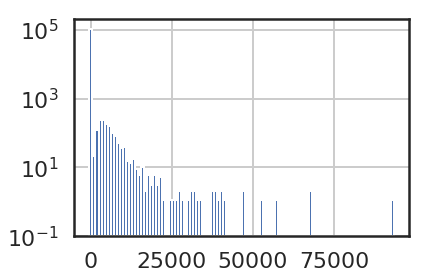

In [326]:
fig, ax = plt.subplots()
df.roll_Z_daily_dist.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

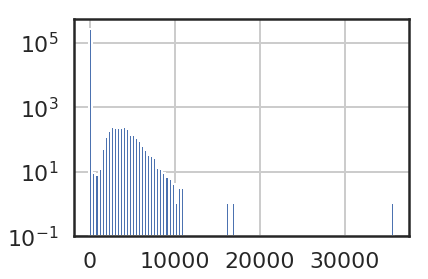

In [330]:
fig, ax = plt.subplots()
df.roll_Z_dist.hist(ax=ax, bins=100, bottom=0.1)
ax.set_yscale('log')

In [332]:
df['dist_outlier'] = np.where(df['roll_Z_dist'] > 5,-1,1); df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,hourly,daily,monthly,weekday,credit_card_limit,lat,lon,distance,Z_dist,Z_daily_dist,roll_Z_daily_dist,dist_outlier,roll_Z_hourly_dist,roll_Z_dist
277391,9484591448272784,2015-07-31 09:39:48,17.99,-90.045639,29.889039,9,2015-07-31 09:00:00,2015-07-31,2015-07,4,4000,29.96,-90.08,8.557223,NaN,2.142313,NaN,1,NaN,NaN
201068,7053196367895112,2015-07-31 11:03:48,12.09,-74.027561,40.689615,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,18000,40.75,-73.99,7.423284,NaN,0.815180,NaN,1,NaN,NaN
278181,9528285469413252,2015-07-31 11:10:14,78.21,-72.139485,43.108100,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,40000,43.19,-72.09,9.952420,NaN,1.427295,NaN,1,NaN,NaN
29066,1845720274833905,2015-07-31 11:28:55,74.41,-89.002148,40.804323,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,20000,40.80,-89.00,0.513627,NaN,-1.778619,NaN,1,NaN,NaN
230996,7850942767136368,2015-07-31 11:38:51,54.89,-72.025675,43.210753,11,2015-07-31 11:00:00,2015-07-31,2015-07,4,4000,43.19,-72.09,5.701868,NaN,-0.058782,NaN,1,NaN,NaN


In [334]:
df['dist_outlier'].value_counts()

 1    261986
-1      3183
Name: dist_outlier, dtype: int64

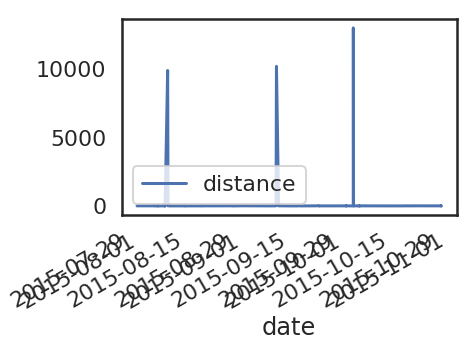

In [337]:
# let's look at the cc user with the highest weekly distance Z-score 
hits = df[df['dist_outlier'] == -1]

# get top hit
hits['credit_card'].iloc[0]

# subset df for transactions for that user, then plot transactions by time (X) and distance from home (Y)
top_hit = df[df['credit_card'] == hits['credit_card'].iloc[0]].sort_values(['date'])
top_hit.plot(x='date', y='distance')

In [96]:
df.loc[:,'Z_weekly_dist'] = df.groupby(['credit_card', 'weekly'])['distance'].transform(zscore)
df.loc[:,'Z_monthly_dist'] = df.groupby(['credit_card', 'monthly'])['distance'].transform(zscore)
df.head()

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance,Z_daily_dist,Z_weekly_dist,Z_monthly_dist
0,1003715054175576,2015-09-11 00:32:40,43.78,-80.174132,40.267370,2015-09-11,2015-09-07/2015-09-13,2015-09,20000,40.24,-80.22,4.941044,-1.460741,-0.218889,-0.214114
1,1003715054175576,2015-10-24 22:23:08,103.15,-80.194240,40.180114,2015-10-24,2015-10-19/2015-10-25,2015-10,20000,40.24,-80.22,7.009149,0.505766,-0.223295,-0.140486
2,1003715054175576,2015-10-26 18:19:36,48.55,-80.211033,40.313004,2015-10-26,2015-10-26/2015-11-01,2015-10,20000,40.24,-80.22,8.153301,-1.004758,-0.300978,-0.139969
3,1003715054175576,2015-10-22 19:41:10,136.18,-80.174138,40.290895,2015-10-22,2015-10-19/2015-10-25,2015-10,20000,40.24,-80.22,6.868058,0.987441,-0.223328,-0.140550
4,1003715054175576,2015-10-26 20:08:22,71.82,-80.238720,40.166719,2015-10-26,2015-10-26/2015-11-01,2015-10,20000,40.24,-80.22,8.302105,0.995174,-0.300911,-0.139902


In [97]:
# ok, take a peak at the daily outliers again, see how weekly and monthly compare
df.sort_values(by = ['Z_daily_dist'], ascending= False).head()

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance,Z_daily_dist,Z_weekly_dist,Z_monthly_dist
42137,2239759218122779,2015-08-28 16:42:20,122.65,144.284759,-1.198259,2015-08-28,2015-08-24/2015-08-30,2015-08,20000,43.19,-72.09,14116.978859,4.587315,5.710663,9.249969
243804,8239191573771235,2015-09-11 20:20:47,134.26,-5.900254,57.705450,2015-09-11,2015-09-07/2015-09-13,2015-09,21000,18.49,-67.10,6581.698828,4.477207,4.841420,3.448138
150877,5458162124475323,2015-09-04 07:55:23,41.53,104.943746,23.902295,2015-09-04,2015-08-31/2015-09-06,2015-09,20000,43.10,-76.41,12563.501782,4.248527,7.349678,7.107595
36654,2089905184376958,2015-09-11 20:44:37,68.85,28.154081,-8.520793,2015-09-11,2015-09-07/2015-09-13,2015-09,30000,42.57,-77.46,11923.844504,4.129482,7.550949,6.295960
134929,5059189477453448,2015-10-16 14:41:02,97.06,35.351005,-0.032718,2015-10-16,2015-10-12/2015-10-18,2015-10,42000,46.32,-67.85,11019.257964,4.129482,7.484458,12.493642


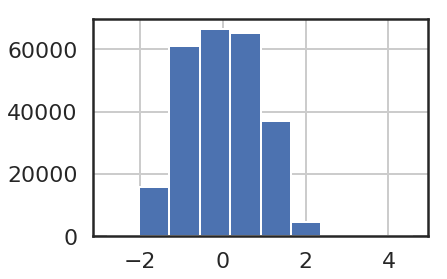

In [119]:
df.Z_daily_dist.hist()

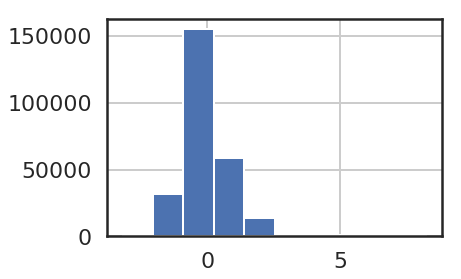

In [120]:
df.Z_weekly_dist.hist()

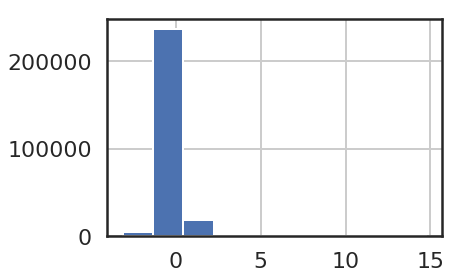

In [121]:
df.Z_monthly_dist.hist()

The weekly and monthly Z's are even more extreme. 

Probably need to compute the moving average, not the stationary... 

I'm going to use the daily Z-score to flag for now.


### Engineer Z-scores for spend

Here I'm going to be a little more biased, but it'll allow me to sample from a bigger group. 

I'm going to calculate the Z-score for the amount of a given transaction, using the 'limit' as a grouping variable. 

My logic is that the limit should be related to the buying power of an individual. Someone with more buying power (i.e. higher income) probably has different spending habits than someone with a lower limit. Therefore, we should be able to look at group dynamics and see if something is way off. 

I think daily might be noisy, but I expect weekly and monthly will give good signal

In [99]:
df.loc[:,'Z_daily_spend'] = df.groupby(['credit_card_limit', 'daily'])['transaction_dollar_amount'].transform(zscore)
df.loc[:,'Z_weekly_spend'] = df.groupby(['credit_card_limit', 'weekly'])['transaction_dollar_amount'].transform(zscore)
df.loc[:,'Z_monthly_spend'] = df.groupby(['credit_card_limit', 'monthly'])['transaction_dollar_amount'].transform(zscore)

# sort values by weekly spend Z
df.sort_values(by = ['Z_weekly_spend'], ascending= False).head()

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance,Z_daily_dist,Z_weekly_dist,Z_monthly_dist,Z_daily_spend,Z_weekly_spend,Z_monthly_spend
179821,6270963060103806,2015-08-15 17:29:20,992.82,-75.938506,41.386083,2015-08-15,2015-08-10/2015-08-16,2015-08,21000,41.30,-76.00,10.861729,0.498039,1.195693,1.246764,8.413653,10.520247,7.148606
207202,7193900293112316,2015-10-15 21:12:39,924.29,-74.045728,40.777317,2015-10-15,2015-10-12/2015-10-18,2015-10,24000,40.75,-73.99,5.590631,0.061429,-0.166694,-0.119784,7.839631,10.424461,6.607241
242522,8221913653327075,2015-08-29 00:04:24,871.63,-85.563832,41.616162,2015-08-29,2015-08-24/2015-08-30,2015-08,25000,41.57,-85.54,5.502335,-0.526207,-0.147721,-0.075951,7.249714,10.251767,5.398621
31047,1981294676906345,2015-09-26 22:50:50,920.85,-70.282104,43.605321,2015-09-26,2015-09-21/2015-09-27,2015-09,5000,43.66,-70.26,6.334934,0.618939,-0.276757,-0.121229,9.140621,10.240204,8.141678
151808,5527951937235136,2015-08-09 23:16:24,946.70,-72.059985,43.144651,2015-08-09,2015-08-03/2015-08-09,2015-08,6000,43.19,-72.09,5.599406,NaN,-0.091548,-0.176771,5.380315,10.036172,7.790258


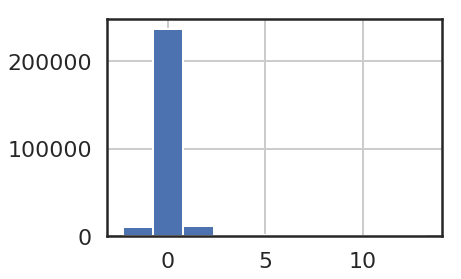

In [122]:
df.Z_daily_spend.hist()

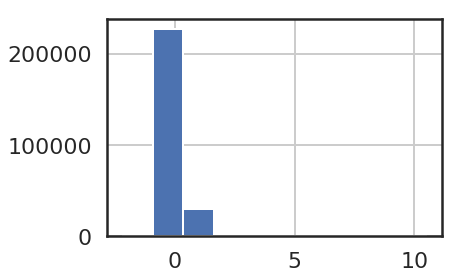

In [123]:
df.Z_weekly_spend.hist()

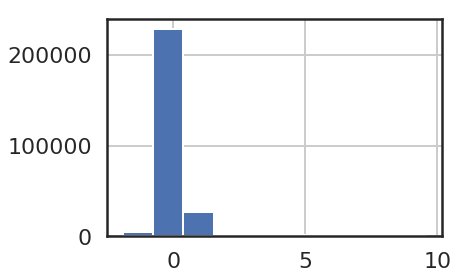

In [124]:
df.Z_monthly_spend.hist()

I don't think that's actually that informative. That's OK, at least we looked.

If time, I'll come back and engineer more features. I think tx frequency might be important, but frankly distance makes the most sense. 

## Analysis / Modeling

I want to visualize of my findings above. Namely, I want to explore transactions as a function of distance over time. 

### Plot Timeseries

,credit_card,date,transaction_dollar_amount,Long,Lat,daily,weekly,monthly,credit_card_limit,lat,lon,distance,Z_daily_dist,Z_weekly_dist,Z_monthly_dist,Z_daily_spend,Z_weekly_spend,Z_monthly_spend
259170,8702495698901225,2015-08-05 22:21:00,70.06,-173.790091,40.894910,2015-08-05,2015-08-03/2015-08-09,2015-08,30000,40.240,-80.22,7475.996075,2.666665,8.247045,6.855899,-0.533759,-0.487970,-0.484085
26637,1786706888116468,2015-10-07 20:57:03,12.91,28.364056,22.238701,2015-10-07,2015-10-05/2015-10-11,2015-10,12000,35.500,-105.10,11939.380898,3.015112,8.000898,6.998402,-0.508679,-0.493001,-0.521083
168962,5930630722779265,2015-08-18 16:20:56,176.30,-1.949445,-20.023214,2015-08-18,2015-08-17/2015-08-23,2015-08,35000,40.800,-89.00,11206.869792,2.474873,7.811226,6.170784,0.610054,0.327803,0.256724
14554,1388343943378591,2015-08-08 01:21:09,5.20,27.869716,46.487621,2015-08-08,2015-08-03/2015-08-09,2015-08,20000,38.148,-81.45,8273.490898,3.474395,7.746994,5.385771,-0.716988,-0.740457,-0.720525
240547,8162218322673975,2015-10-15 19:55:11,26.07,103.207154,16.646398,2015-10-15,2015-10-12/2015-10-18,2015-10,20000,43.000,-78.50,13380.434971,3.474396,7.682203,11.815594,-0.568262,-0.536535,-0.552595


8702495698901225

In [264]:
top_hit

,credit_card,date,transaction_dollar_amount,Long,Lat,hour,daily,monthly,weekday,credit_card_limit,lat,lon,distance
hourly,,,,,,,,,,,,,
2015-07-31 13:00:00,8702495698901225,2015-07-31 13:54:20,75.53,-0.950026,33.570893,13,2015-07-31,2015-07,4,30000,40.24,-80.22,6849.592242
2015-07-31 19:00:00,8702495698901225,2015-07-31 19:11:57,68.68,-80.256665,40.189887,19,2015-07-31,2015-07,4,30000,40.24,-80.22,6.383035
2015-07-31 19:00:00,8702495698901225,2015-07-31 19:13:19,161.12,-80.236561,40.217899,19,2015-07-31,2015-07,4,30000,40.24,-80.22,2.831248
2015-07-31 19:00:00,8702495698901225,2015-07-31 19:52:22,124.17,-80.259519,40.287446,19,2015-07-31,2015-07,4,30000,40.24,-80.22,6.251166
2015-07-31 20:00:00,8702495698901225,2015-07-31 20:23:23,133.05,-80.169812,40.198543,20,2015-07-31,2015-07,4,30000,40.24,-80.22,6.277616
2015-07-31 21:00:00,8702495698901225,2015-07-31 21:13:49,106.85,-80.286073,40.209963,21,2015-07-31,2015-07,4,30000,40.24,-80.22,6.528550
2015-07-31 21:00:00,8702495698901225,2015-07-31 21:32:33,83.31,-80.280699,40.301865,21,2015-07-31,2015-07,4,30000,40.24,-80.22,8.593196
2015-07-31 21:00:00,8702495698901225,2015-07-31 21:35:56,100.06,-80.193673,40.247657,21,2015-07-31,2015-07,4,30000,40.24,-80.22,2.391218
2015-07-31 22:00:00,8702495698901225,2015-07-31 22:20:34,172.10,-80.226221,40.223684,22,2015-07-31,2015-07,4,30000,40.24,-80.22,1.889524


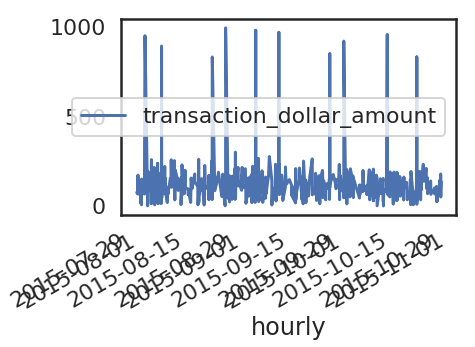

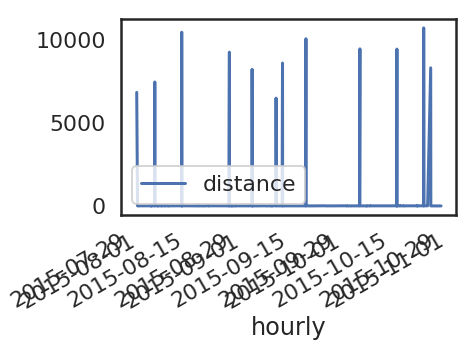

In [265]:
top_hit.plot(y='distance')

It's possible this person just travels frequently, it looks pretty regular. 

Or, this person is getting hacked, a lot.

Check the the patterns in the weekly data.

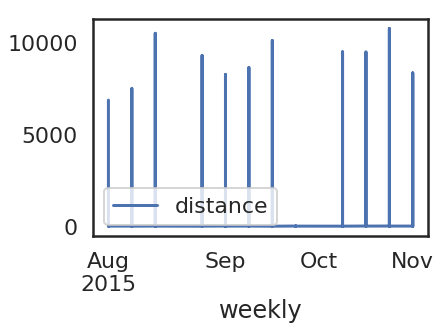

In [118]:
# subset df for transactions for that user, then plot transactions by time (X) and distance from home (Y)
top_hit = df[df['credit_card'] == hits['credit_card'].iloc[0]].sort_values(['date'])
top_hit.plot(x='weekly', y='distance')

It looks like this person is a regular traveler. 

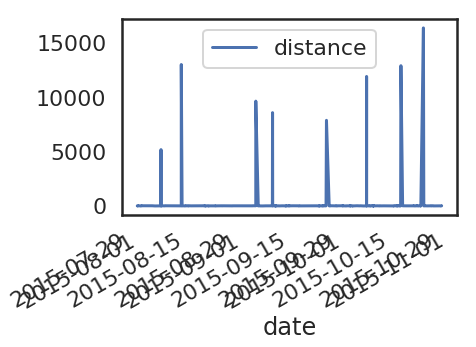

In [111]:
# Check #2 in the list
top_hit = df[df['credit_card'] == hits['credit_card'].iloc[1]]
top_hit.plot(x='date', y='distance')

### Clustering Methods

I'm going to try dimensionality reduction using the tx amount, distance, limit, hour, and weekday measures. 

First, I need to scale the data. Then, after scaling, I'm going to run PCA to reduce the dimensionality, then visualize the data and see if any clusters emerge.

In [140]:
df.columns

Index(['credit_card', 'date', 'transaction_dollar_amount', 'Long', 'Lat',
       'daily', 'weekly', 'monthly', 'hourly', 'weekday', 'hour',
       'credit_card_limit', 'lat', 'lon', 'distance'],
      dtype='object')

In [176]:
from sklearn import preprocessing
from sklearn.decomposition import PCA

# Take useful feature and standardize them
data = df[['transaction_dollar_amount', 'credit_card_limit', 'distance', 'Long', 'Lat', 'hour', 'weekday']]
scaler = preprocessing.StandardScaler()
np_scaled = scaler.fit_transform(data)
data = pd.DataFrame(np_scaled)
# reduce to 2 features
pca = PCA(n_components=2)
dr_data = pca.fit_transform(data)

/home/jim/anaconda3/lib/python3.7/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/home/jim/anaconda3/lib/python3.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


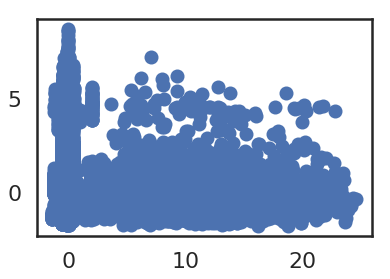

In [177]:
fig, ax = plt.subplots()
ax.scatter(dr_data[:,0], dr_data[:,1])
plt.show()

In [213]:
# try using tSNE
from sklearn.manifold import TSNE
tsne = TSNE(n_components=2, verbose=1, perplexity=40, n_iter=300)
tsne_res = tsne.fit_transform(dr_data)

[t-SNE] Computing 121 nearest neighbors...
[t-SNE] Indexed 265169 samples in 0.303s...
[t-SNE] Computed neighbors for 265169 samples in 5.630s...
[t-SNE] Computed conditional probabilities for sample 1000 / 265169
[t-SNE] Computed conditional probabilities for sample 2000 / 265169
[t-SNE] Computed conditional probabilities for sample 3000 / 265169
[t-SNE] Computed conditional probabilities for sample 4000 / 265169
[t-SNE] Computed conditional probabilities for sample 5000 / 265169
[t-SNE] Computed conditional probabilities for sample 6000 / 265169
[t-SNE] Computed conditional probabilities for sample 7000 / 265169
[t-SNE] Computed conditional probabilities for sample 8000 / 265169
[t-SNE] Computed conditional probabilities for sample 9000 / 265169
[t-SNE] Computed conditional probabilities for sample 10000 / 265169
[t-SNE] Computed conditional probabilities for sample 11000 / 265169
[t-SNE] Computed conditional probabilities for sample 12000 / 265169
[t-SNE] Computed conditional probab

[t-SNE] Computed conditional probabilities for sample 148000 / 265169
[t-SNE] Computed conditional probabilities for sample 149000 / 265169
[t-SNE] Computed conditional probabilities for sample 150000 / 265169
[t-SNE] Computed conditional probabilities for sample 151000 / 265169
[t-SNE] Computed conditional probabilities for sample 152000 / 265169
[t-SNE] Computed conditional probabilities for sample 153000 / 265169
[t-SNE] Computed conditional probabilities for sample 154000 / 265169
[t-SNE] Computed conditional probabilities for sample 155000 / 265169
[t-SNE] Computed conditional probabilities for sample 156000 / 265169
[t-SNE] Computed conditional probabilities for sample 157000 / 265169
[t-SNE] Computed conditional probabilities for sample 158000 / 265169
[t-SNE] Computed conditional probabilities for sample 159000 / 265169
[t-SNE] Computed conditional probabilities for sample 160000 / 265169
[t-SNE] Computed conditional probabilities for sample 161000 / 265169
[t-SNE] Computed con

[t-SNE] KL divergence after 250 iterations with early exaggeration: 104.753052
[t-SNE] KL divergence after 300 iterations: 6.243421


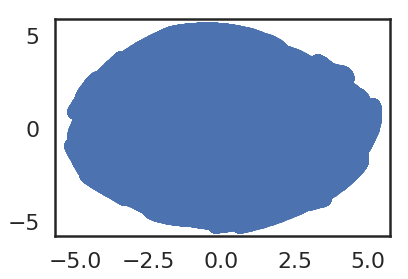

In [214]:
fig, ax = plt.subplots()
ax.scatter(tsne_res[:,0], tsne_res[:,1])
plt.show()

### KMeans

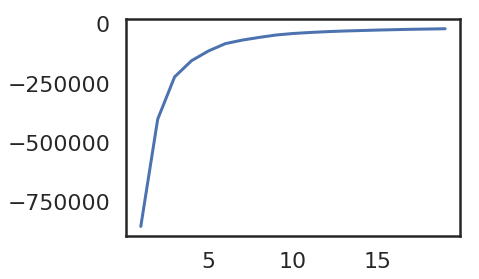

In [178]:
from sklearn.cluster import KMeans

# calculate with different number of centroids to see the loss plot (elbow method)
n_cluster = range(1, 20)
kmeans = [KMeans(n_clusters=i).fit(dr_data) for i in n_cluster]
scores = [kmeans[i].score(dr_data) for i in range(len(kmeans))]
fig, ax = plt.subplots()
ax.plot(n_cluster, scores)
plt.show()

In [180]:
pd.DataFrame([n_cluster, scores])

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18
0,1.00000,2.000000,3.000000,4.000000,5.000000,6.000000,7.000000,8.000000,9.000000,10.000000,11.000000,12.000000,13.00000,14.000000,15.000000,16.00000,17.000000,18.000000,19.000000
1,-854758.73316,-401921.830498,-223236.582834,-154998.817817,-113829.067267,-82834.475489,-67933.663716,-56562.457618,-46344.290425,-40053.489681,-35753.024891,-32235.377529,-29603.13782,-27578.422652,-25553.387774,-23804.95389,-22289.652292,-21139.847322,-19947.928824


Using the elbow method, it looks likes 7 is a decent number to start with. Let's see what that look's like.

In [202]:
# train kmeans model
kmeans = KMeans(n_clusters=7, random_state=42).fit(dr_data)

# generate labels
kmeans_clusters = kmeans.predict(dr_data)

In [206]:
all_data = pd.DataFrame(dr_data)
all_data['km_clusters'] = kmeans_clusters
all_data['km_clusters'].value_counts()

0    113053
3    106270
1     33104
4      6164
6      3352
5      2057
2      1169
Name: km_clusters, dtype: int64

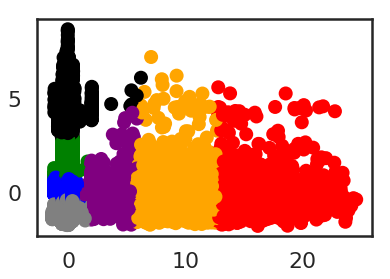

In [207]:
fig, ax = plt.subplots()
colors = {0:'grey', 1:'green', 2:'red', 3:'blue', 4:'black', 5:'orange', 6:'purple'}
ax.scatter(all_data[0], all_data[1], c=all_data["km_clusters"].apply(lambda x: colors[x]))
plt.show()

In [ ]:
# that looks terrible
# distance-based methods are dumb
# try density and tree methods

In [211]:
# call centers
clusters_centers = kmeans.cluster_centers_
# calculate distance of each point from nearest center
dist = [np.linalg.norm(x-y) for x,y in zip(dr_data,clusters_centers[kmeans_clusters])]

# label outliers (99% cutoff) 
km_dist=np.array(dist)
km_dist[dist>=np.percentile(dist,99)]=1
km_dist[dist<np.percentile(dist,99)]=0
all_data['km_outliers'] = km_dist

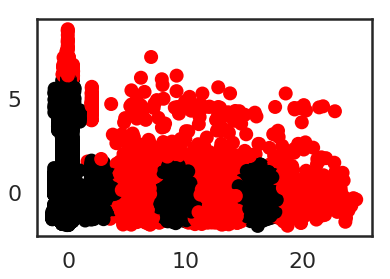

In [212]:
fig, ax = plt.subplots()
colors = {0:'black', 1:'red'}
ax.scatter(all_data[0], all_data[1], c=all_data["km_outliers"].apply(lambda x: colors[x]))
plt.show()

### isolation Forest

## Results

## Conclusions and Next Steps